In [1]:
import os
import math
import random

import numpy as np
import tensorflow as tf
import cv2

slim = tf.contrib.slim

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
import sys
sys.path.append('../')

In [4]:
from nets import ssd_vgg_300, ssd_common, np_methods
from preprocessing import ssd_vgg_preprocessing
from notebooks import visualization

In [5]:
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)

## SSD 300 Model

The SSD 300 network takes 300x300 image inputs. In order to feed any image, the latter is resize to this input shape (i.e.`Resize.WARP_RESIZE`). Note that even though it may change the ratio width / height, the SSD model performs well on resized images (and it is the default behaviour in the original Caffe implementation).

SSD anchors correspond to the default bounding boxes encoded in the network. The SSD net output provides offset on the coordinates and dimensions of these anchors.

In [6]:
# Input placeholder.
net_shape = (300, 300)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_300.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse)

# Restore SSD model.
# ckpt_filename = '../checkpoints/ssd_300_vgg.ckpt'
ckpt_filename = '../log/WF_addbolck3/model.ckpt-17641'
# ckpt_filename = '../log/modified_verticalbox_nopretrainvgg/model.ckpt-4339'
# ckpt_filename = '../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt'
isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

# SSD default anchor boxes.
ssd_anchors = ssd_net.anchors(net_shape)

INFO:tensorflow:Restoring parameters from ../log/WF_addbolck3/model.ckpt-17641


## Post-processing pipeline

The SSD outputs need to be post-processed to provide proper detections. Namely, we follow these common steps:

* Select boxes above a classification threshold;
* Clip boxes to the image shape;
* Apply the Non-Maximum-Selection algorithm: fuse together boxes whose Jaccard score > threshold;
* If necessary, resize bounding boxes to original image shape.

In [7]:
# Main image processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=.45, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, ssd_anchors,
#             select_threshold=0.2, 
            select_threshold=select_threshold, 
        img_shape=net_shape, num_classes=2, decode=True)
    
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=100000)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, 
#                                                        nms_threshold=0.8
                                                       nms_threshold=nms_threshold
                                                      )
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes

In [8]:
import utils
import re
import os
def util_process_image(isess, path, path_cropped, image_name, nums, select_threshold=0.5, nms_threshold=.45, net_shape=(300, 300)):
    
    path_cropped_lst = utils.crop_img(path, path_cropped, image_name, nums)
    
    record_classes = []
    record_scores = []
    record_bboxes = []

    for cropped_image_path in path_cropped_lst:
        img = mpimg.imread(cropped_image_path)
        num, coo = int(re.split('_|\.',cropped_image_path)[-3]), re.split('_|\.',cropped_image_path)[-2]
        x_idx, y_idx = int(re.split(',|\(|\)',coo)[1]), int(re.split(',|\(|\)',coo)[2])

        rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                                  feed_dict={img_input: img})
        rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(rpredictions, rlocalisations, ssd_anchors,
                                                                  select_threshold=select_threshold, 
                                                                  img_shape=net_shape, num_classes=2, decode=True)
        rbboxes /= num
        rbboxes[:,0] += y_idx/num
        rbboxes[:,1] += x_idx/num
        rbboxes[:,2] += y_idx/num
        rbboxes[:,3] += x_idx/num

        record_classes.append(rclasses)
        record_scores.append(rscores)
        record_bboxes.append(rbboxes)
    rclasses, rscores, rbboxes = np.hstack(record_classes), np.hstack(record_scores), np.vstack(record_bboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=100000)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    for cropped_image_path in path_cropped_lst:
        os.remove(cropped_image_path)
    
    return rclasses, rscores, rbboxes

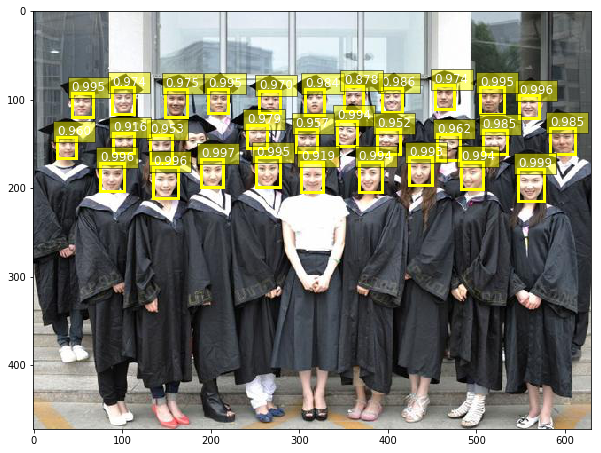

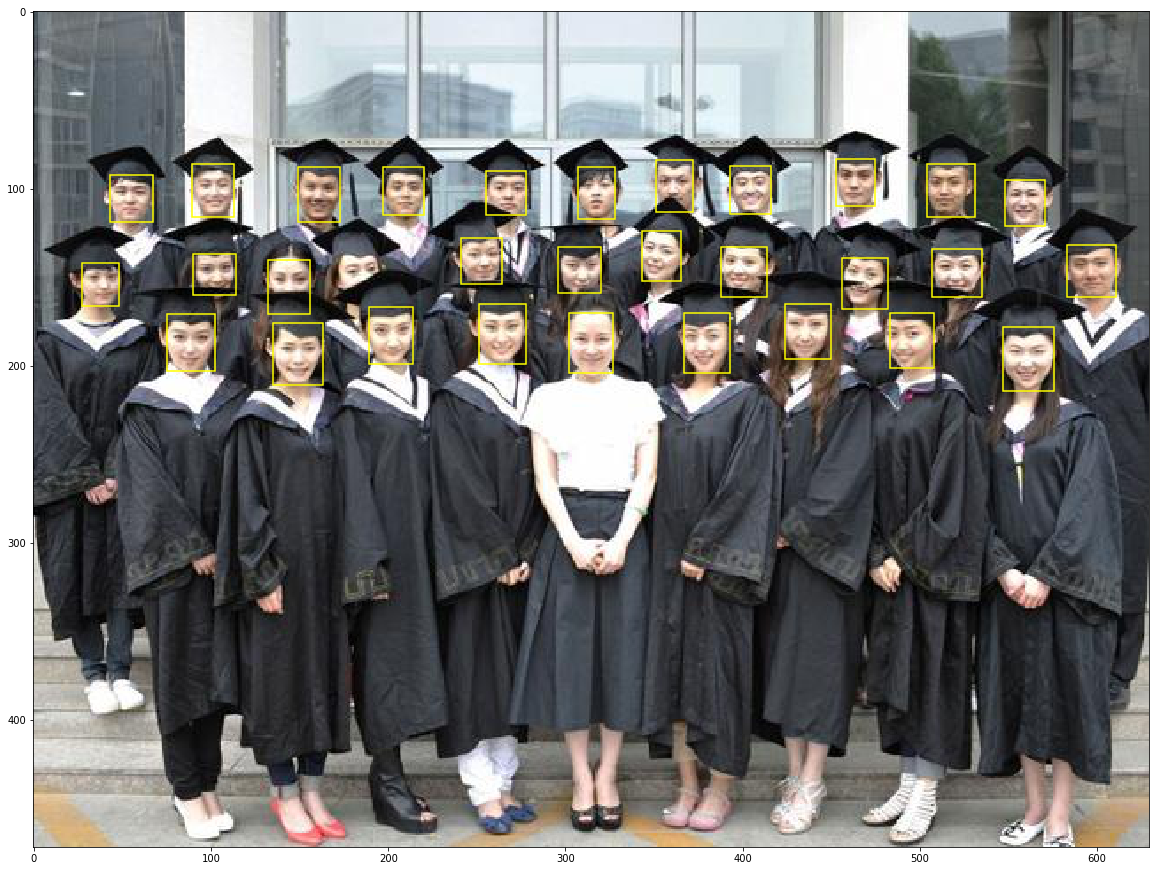

CPU times: user 3 s, sys: 428 ms, total: 3.42 s
Wall time: 3.09 s


In [16]:
%%time

path = '../demo/'
path_cropped = '../demo/cropped/'
image_name = 'face_1.jpg'
nums = [i+2 for i in range(5)]
rclasses, rscores, rbboxes = util_process_image(isess, path, path_cropped, image_name, nums\
                                                , select_threshold=0.76,nms_threshold=.1)
img = mpimg.imread(path + image_name)
visualization.plt_bboxes_one(img, rclasses, rscores, rbboxes, idx=1, figsize=(10,10), linewidth = 3)
visualization.plt_bboxes_face(img, rclasses, rscores, rbboxes, figsize=(20,20), linewidth = 1.5)

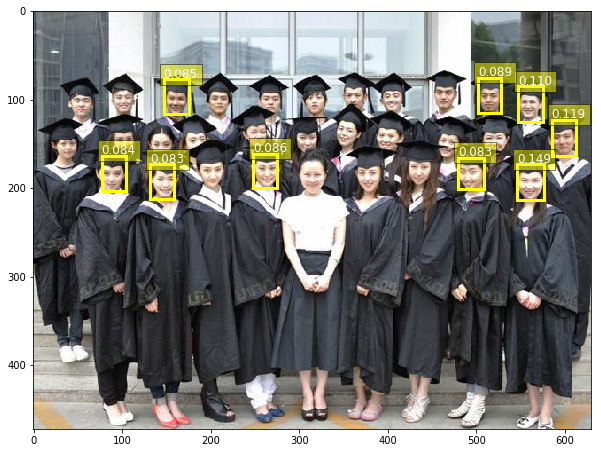

CPU times: user 411 ms, sys: 0 ns, total: 411 ms
Wall time: 390 ms


In [12]:
%%time
# Test on some demo image and visualize output.
path = '../demo/'
image_names = sorted(os.listdir(path))
image_name = 'face_1.jpg'

# img = mpimg.imread(path + image_names[-1])
img = mpimg.imread(
    path + image_name
#     '../demo/cropped/face_1_2_(0,0).jpg'
)
# for select_threshold in range(10,0,-1):
rclasses, rscores, rbboxes =  process_image(img, select_threshold=0.08, nms_threshold=.1)
#     visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes_one(img, rclasses, rscores, rbboxes, idx=1, figsize=(10,10), linewidth = 3)
# visualization.plt_bboxes_face(img, rclasses, rscores, rbboxes, figsize=(10,10), linewidth = 1.5)

In [8]:
# %%time
# # Test on some demo image and visualize output.
# path = '../demo/'
# image_names = sorted(os.listdir(path))
# # image_name = 'eagle.jpg'
# COUNT = 0
# for image_name in image_names:
#     if image_name != '.ipynb_checkpoints':
#         COUNT += 1
# #     img = mpimg.imread(path + image_names[-4])
#         img = mpimg.imread(path + image_name)
#         rclasses, rscores, rbboxes =  process_image(img,select_threshold=0.09, nms_threshold=0.0001)

#         # visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
#         visualization.plt_bboxes(img, rclasses, rscores, rbboxes)
# print(COUNT)

In [44]:
loss_hist = []
with open('../log/WF_addbolck3/loss_hist.txt','r') as f:
#     k =f.readlines()
    for line in f.readlines():
        if line.startswith('INFO:tensorflow:global step '):
            try:
                loss_hist.append(float(line.strip().split()[-3]))
            except:
                print(line.strip().split())

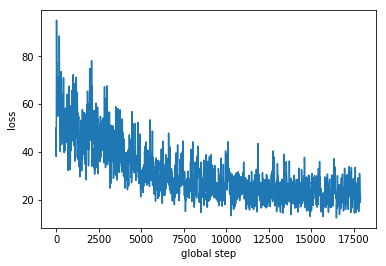

In [45]:
import matplotlib.pyplot as plt
import numpy as np
ax = plt.subplot(111)
t1 = np.arange(0, len(loss_hist)*10, 10)
plt.plot(t1,loss_hist, label="train")
ax.set_ylabel('loss')
ax.set_xlabel('global step')

plt.show()

In [46]:
k = 100
loss_ave = [sum(loss_hist[i:k+i])/k for i in range(len(loss_hist[:-k]))] 

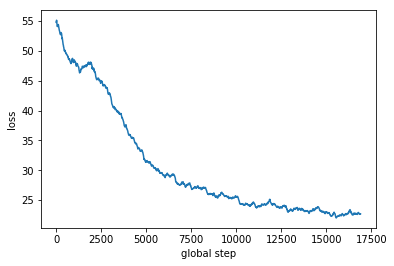

In [47]:
ax = plt.subplot(111)
t1 = np.arange(0, len(loss_ave)*10, 10)
plt.plot(t1,loss_ave, label="train")
ax.set_ylabel('loss')
ax.set_xlabel('global step')

plt.show()

In [26]:
loss_ave.index(min(loss_ave))

294

In [27]:
len(loss_ave)

431